# **Baseline BiLSTM Model (No Optimization)**


## **Imports**

In [16]:
import pandas as pd
import os
import numpy as np
import random
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from torch.cuda.amp import GradScaler
from collections import Counter
import re
import seaborn as sns

np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
SEED = 42
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

USE_AMP = torch.cuda.is_available()
scaler = GradScaler() if USE_AMP else None

print(f"Using device: {DEVICE}")
print(f"Using mixed precision (AMP): {USE_AMP}")

Using device: cuda
Using mixed precision (AMP): True


C:\Users\Mohammed Hassan\AppData\Local\Temp\ipykernel_17364\725345992.py:24: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if USE_AMP else None


## **Load Data**

In [17]:
# import kagglehub
# kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")


In [18]:
import csv
df = pd.read_csv("IMDB Dataset.csv", sep=",", quotechar='"', quoting=csv.QUOTE_MINIMAL, escapechar="\\", engine="python")
print(df.head())
print(df["sentiment"].value_counts())
print("Total samples:", len(df))

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Total samples: 50000


In [19]:
# Encode labels
df["label"] = df["sentiment"].map({"negative": 0, "positive": 1})

# Use full dataset (50k) or sample for faster training
USE_FULL_DATA = True  # Set to False for quick testing

if USE_FULL_DATA:
    print("Using FULL 50k dataset")
else:
    df = df.groupby("label", group_keys=False).apply(
        lambda x: x.sample(n=5000, random_state=SEED)
    ).reset_index(drop=True)
    print("Using sampled 10k dataset")

print(f"Dataset size: {len(df)}")
print(df["label"].value_counts())

Using FULL 50k dataset
Dataset size: 50000
label
1    25000
0    25000
Name: count, dtype: int64


In [20]:
X = df["review"].values
y = df["label"].values

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, stratify=y, random_state=SEED)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=SEED)

print(f"Train: {len(X_train)}")
print(f"Validation: {len(X_val)}")
print(f"Test: {len(X_test)}")

Train: 40000
Validation: 5000
Test: 5000


## **Tokenization**

In [21]:
MAX_VOCAB = 30000
MAX_LEN = 150
BATCH_SIZE = 64

class SimpleTokenizer:
    def __init__(self, num_words=None, oov_token="<OOV>"):
        self.num_words = num_words
        self.oov_token = oov_token
        self.word_index = {}
        
    def fit_on_texts(self, texts):
        word_counts = Counter()
        for text in texts:
            words = re.findall(r'\b\w+\b', text.lower())
            word_counts.update(words)
        
        self.word_index[self.oov_token] = 1
        for idx, (word, _) in enumerate(word_counts.most_common(self.num_words - 2), start=2):
            self.word_index[word] = idx
    
    def texts_to_sequences(self, texts):
        sequences = []
        for text in texts:
            words = re.findall(r'\b\w+\b', text.lower())
            seq = [self.word_index.get(w, 1) for w in words]
            sequences.append(seq)
        return sequences

def pad_sequences(sequences, maxlen, padding='post', truncating='post', value=0):
    result = np.full((len(sequences), maxlen), value, dtype=np.int64)
    for i, seq in enumerate(sequences):
        if len(seq) > maxlen:
            result[i] = seq[:maxlen] if truncating == 'post' else seq[-maxlen:]
        else:
            if padding == 'post':
                result[i, :len(seq)] = seq
            else:
                result[i, -len(seq):] = seq
    return result

tokenizer = SimpleTokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN)
X_val_seq = pad_sequences(tokenizer.texts_to_sequences(X_val), maxlen=MAX_LEN)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=MAX_LEN)

print(f"Train shape: {X_train_seq.shape}")
print(f"Val shape: {X_val_seq.shape}")
print(f"Test shape: {X_test_seq.shape}")

Train shape: (40000, 150)
Val shape: (5000, 150)
Test shape: (5000, 150)


In [22]:
class IMDBDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = IMDBDataset(X_train_seq, y_train)
val_ds = IMDBDataset(X_val_seq, y_val)
test_ds = IMDBDataset(X_test_seq, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")


Train batches: 625
Val batches: 79
Test batches: 79


## **Model Definition**

In [23]:
class TextBiLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, output_dim, n_layers, dropout):
        super(TextBiLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(
            embed_dim, hidden_dim, num_layers=n_layers,
            bidirectional=True, dropout=dropout if n_layers > 1 else 0, batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, text):
        embedded = self.embedding(text)
        output, (hidden, cell) = self.lstm(embedded)
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1))
        return self.fc(hidden)


EMBED_DIM = 64
HIDDEN_DIM = 32
DROPOUT = 0.7
LEARNING_RATE = 0.1
N_EPOCHS = 10

model = TextBiLSTM(
    vocab_size=MAX_VOCAB,
    embed_dim=EMBED_DIM,
    hidden_dim=HIDDEN_DIM,
    output_dim=2,
    n_layers=1,
    dropout=DROPOUT
).to(DEVICE)

print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")


TextBiLSTM(
  (embedding): Embedding(30000, 64)
  (lstm): LSTM(64, 32, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.7, inplace=False)
  (fc): Linear(in_features=64, out_features=2, bias=True)
)

Total parameters: 1,945,218


## **Training**

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

history = {"train_loss": [], "val_loss": [], "val_accuracy": []}
best_val_loss = float('inf')
best_model_state = None

print(f"Training for {N_EPOCHS} epochs...")
print("-" * 60)

start_time = time.time()

for epoch in range(N_EPOCHS):
    # Training
    model.train()
    total_loss = 0.0
    
    for x, y in train_loader:
        x, y = x.to(DEVICE), y.to(DEVICE)
        optimizer.zero_grad()
        
        if USE_AMP:
            with torch.amp.autocast('cuda'):
                outputs = model(x)
                loss = criterion(outputs, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(x)
            loss = criterion(outputs, y)
            loss.backward()
            optimizer.step()
        
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    history["train_loss"].append(avg_train_loss)
    
    # Validation
    model.eval()
    val_loss = 0.0
    preds, trues = [], []
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            if USE_AMP:
                with torch.amp.autocast('cuda'):
                    outputs = model(x)
                    loss = criterion(outputs, y)
            else:
                outputs = model(x)
                loss = criterion(outputs, y)
            val_loss += loss.item()
            preds.extend(outputs.argmax(1).cpu().numpy())
            trues.extend(y.cpu().numpy())
    
    avg_val_loss = val_loss / len(val_loader)
    val_acc = accuracy_score(trues, preds)
    history["val_loss"].append(avg_val_loss)
    history["val_accuracy"].append(val_acc)
    
    # Save best
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
        marker = " *"
    else:
        marker = ""
    
    remaining = N_EPOCHS - epoch - 1
    print(f"[{epoch+1}/{N_EPOCHS}] Train={avg_train_loss:.4f} Val={avg_val_loss:.4f} Acc={val_acc:.4f} | {remaining} left{marker}")

train_time = time.time() - start_time
print("-" * 60)
print(f"Training completed in {train_time:.2f}s ({train_time/60:.1f} min)")

# Load best model
model.load_state_dict(best_model_state)


Training for 10 epochs...
------------------------------------------------------------
[1/10] Train=0.8265 Val=0.7238 Acc=0.5144 | 9 left *
[2/10] Train=0.8331 Val=0.7618 Acc=0.5050 | 8 left
[3/10] Train=0.8318 Val=0.7407 Acc=0.5008 | 7 left
[4/10] Train=0.8456 Val=0.7223 Acc=0.5114 | 6 left *
[5/10] Train=0.8535 Val=0.7474 Acc=0.5008 | 5 left
[6/10] Train=0.8487 Val=0.7431 Acc=0.4954 | 4 left
[7/10] Train=0.8489 Val=0.7272 Acc=0.5118 | 3 left
[8/10] Train=0.8405 Val=0.7406 Acc=0.5116 | 2 left
[9/10] Train=0.8386 Val=0.7196 Acc=0.5136 | 1 left *
[10/10] Train=0.8430 Val=0.7358 Acc=0.5036 | 0 left
------------------------------------------------------------
Training completed in 29.53s (0.5 min)


<All keys matched successfully>

## **Evaluation**

In [25]:
model.eval()
preds, trues = [], []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(DEVICE)
        if USE_AMP:
            with torch.amp.autocast('cuda'):
                outputs = model(x)
        else:
            outputs = model(x)
        preds.extend(outputs.argmax(1).cpu().numpy())
        trues.extend(y.numpy())

test_acc = accuracy_score(trues, preds)
print(f"\n{'='*50}")
print(f"TEST ACCURACY: {test_acc:.4f} ({test_acc*100:.2f}%)")
print(f"{'='*50}")

print("\nClassification Report:")
print(classification_report(trues, preds, target_names=["Negative", "Positive"]))



TEST ACCURACY: 0.5036 (50.36%)

Classification Report:
              precision    recall  f1-score   support

    Negative       0.50      0.54      0.52      2500
    Positive       0.50      0.47      0.49      2500

    accuracy                           0.50      5000
   macro avg       0.50      0.50      0.50      5000
weighted avg       0.50      0.50      0.50      5000



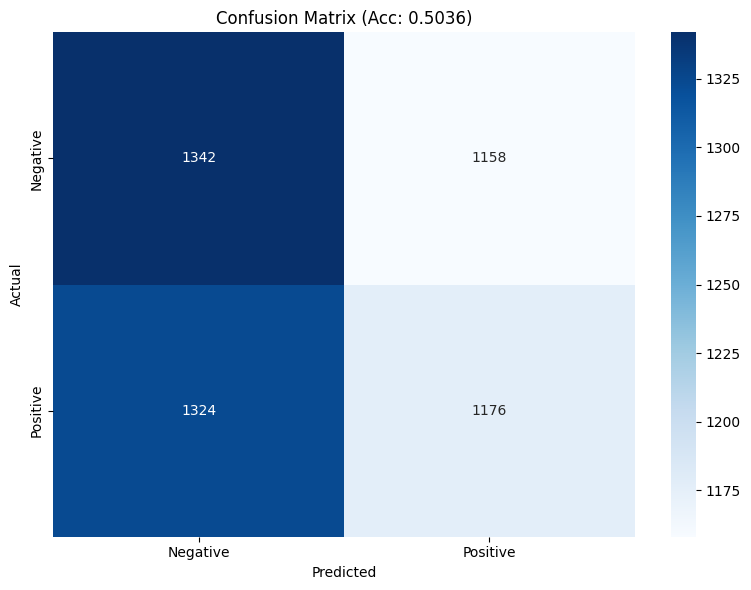

In [26]:
cm = confusion_matrix(trues, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=["Negative", "Positive"],
            yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title(f"Confusion Matrix (Acc: {test_acc:.4f})")
plt.tight_layout()
plt.savefig("results/baseline_confusion_matrix.png", dpi=150)
plt.show()


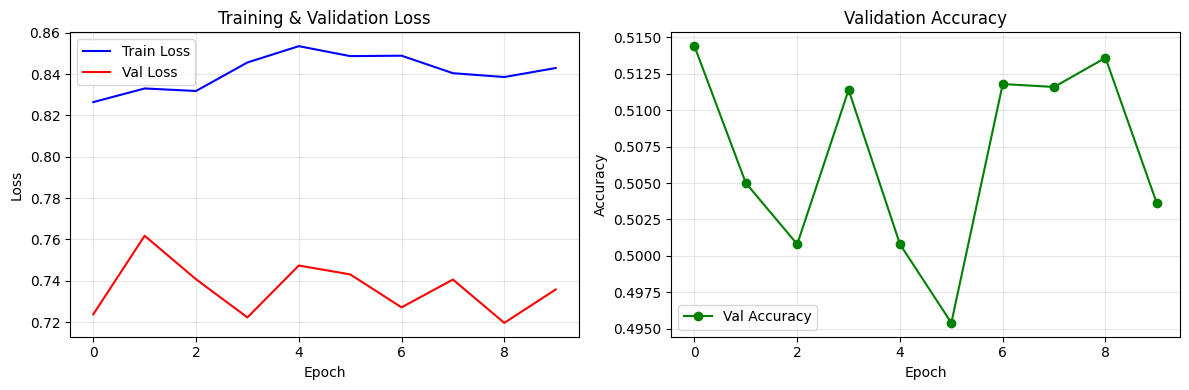

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history["train_loss"], 'b-', label="Train Loss")
axes[0].plot(history["val_loss"], 'r-', label="Val Loss")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Training & Validation Loss")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(history["val_accuracy"], 'g-o', label="Val Accuracy")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_title("Validation Accuracy")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("results/baseline_training_curves.png", dpi=150)
plt.show()


## **Save Results**

In [28]:
import json
os.makedirs("results", exist_ok=True)

# Save model
torch.save(best_model_state, "results/baseline_model.pt")
print("Saved: results/baseline_model.pt")

# Save history
history_df = pd.DataFrame(history)
history_df["epoch"] = range(1, N_EPOCHS + 1)
history_df.to_csv("results/baseline_history.csv", index=False)
print("Saved: results/baseline_history.csv")

# Save summary
summary = {
    "test_accuracy": test_acc,
    "best_val_loss": best_val_loss,
    "best_val_accuracy": max(history["val_accuracy"]),
    "train_time_seconds": train_time,
    "hyperparameters": {
        "embed_dim": EMBED_DIM,
        "hidden_dim": HIDDEN_DIM,
        "dropout": DROPOUT,
        "learning_rate": LEARNING_RATE,
        "epochs": N_EPOCHS,
        "batch_size": BATCH_SIZE,
        "max_len": MAX_LEN,
        "max_vocab": MAX_VOCAB
    }
}

with open("results/baseline_summary.json", "w") as f:
    json.dump(summary, f, indent=2)
print("Saved: results/baseline_summary.json")

print(f"\n{'='*50}")
print("BASELINE COMPLETE!")
print(f"{'='*50}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Training Time: {train_time:.2f}s")

Saved: results/baseline_model.pt
Saved: results/baseline_history.csv
Saved: results/baseline_summary.json

BASELINE COMPLETE!
Test Accuracy: 0.5036
Training Time: 29.53s
